In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy
from scipy.integrate import dblquad

Starting from the following unconstrained model for the data
$$
    Y_i|\beta \sim \mathcal{N}(\int_{T} x_i(t)\beta(t) dt+ \mu, \sigma^2)
$$
$$
    \beta \sim GP(0,K)
$$

Assuming $\mu$ and $\sigma^2$ known, we consider functional coefficients $\beta^0$ equal to zero on a given set $T_0 ⊂ T$.  A random process $\beta^0=\beta^0(t)$ with such a property will be called a constrained random process. 

We can construct a **constrained Gaussian process  $\beta^0$** from the unconstrained
Gaussian process $\beta$ since, with probability one, $\beta$ can be decomposed into the sum of two independent Gaussian random processes $\beta^0$ and $\beta^1$ such that $\beta^0$ is zero on $T^0$. Nevertheless $\beta^0$ and $\beta^1$ share the same smoothness properties with $\beta$.

It can be shown that the distribution of $\beta^0$ can be viewed as the distribution of $\beta$ conditioned by $\beta_\tau=\beta(\tau) = 0$    $∀𝜏∈T_0$

Hence our Bayesian model is:
$$
    Y_i|\beta^0,\mu,\sigma^2 \sim N(\int_{T} \mu + x_i(t)*\beta^0(t) dt, \sigma^2)
$$
$$
    \beta^0|\sigma^2,T_0 \sim GP(0,\sigma^2 K^0)
$$
$$
    p(\mu,\sigma)\propto \frac{1}{\sigma^2}
$$


### Synthetic data generation

The intervals $T$ and $T_0$ are approximated using a finite grid of discrete values:
$$
        t_1,...t_g ∈ T   \text{  ,  }   \tau_1,...\tau_m ∈T_0
$$

While the integral is approximated using rectangle method.


In [2]:
sigma=0.25
mu=0
n=100
t00=-1
t01=1.5
t0=-3
t1=3
g=2**7
T = np.linspace(t0,t1,g)

#m???
step=(t1-t0)/(g-1)
i=t0
while np.abs(i)>np.abs(t00):
    i+=step
T0=np.arange(i, t01, step)
m=T0.size

To project a generic $f(t)$ onto the subspace of functions that vanish on $T_0$ in the RKHS with kernel $K(s, t)$ we do:

$$ f_{proj}(t)=\sum_{t_i ∈ T_0}(c_i K(t_i,t))$$   where $$c_i= \langle f, K(t_i,) \rangle _H =\int_{T_0} f(t)K(t_i,s)dtds  \text{, } t_i ∈ T_0$$


We approximate $\beta^0$ with $\beta^0_{true}$ such that:

$$ 
f(t)=sin(t \pi/4) \text{ and } f_{proj}(t)=\beta^{0}_{true}(t)
$$



In [3]:
#f(t) to project
def original_function(t): 
    return np.sin(t * np.pi / 4)

def gaussian_kernel(s, t):
    return np.exp(-2*(s - t)**2) 

#projection coefficients i.e. approx of inner products (c_i)
def projection_coefficient(t,i, kernel, interval):
    result, _ = dblquad(lambda s, t: original_function(t) *kernel(i,s), interval[0], interval[-1], lambda _: interval[0], lambda _: interval[-1])
    return result

#projected function i.e. beta0_true(t)
def projected_function(t, kernel, interval):
    return sum(projection_coefficient(t,i, kernel, interval) * kernel(i, t) for i in interval)


    
#rectangle for approx of integrals
def rect(t0,t1,f,k=None,proj=None): 
    n_rect=30 
    h=(t1-t0)/n_rect
    summ=0
    if  proj is None and k is None:   #to evaluate the integral of a funct
        for i in range(t0,t1):
            summ += f[np.abs(T - (i+h)/2).argmin()]
    else:
        for i in range(t0,t1): #specifically to evaluate the integral of a funct*beta0
            summ += f[np.abs(T - (i+h)/2).argmin()]*proj(np.abs(T - (i+h)/2).argmin(),k,T0) 
    return summ*h
    
    
# covariate generation
np.random.seed(2326)
K = np.zeros((g,g))
for i in range(g):
    for j in range(g):
        K[i,j]=gaussian_kernel(T[i],T[j])        
x = np.random.multivariate_normal(np.zeros(g),K,n)  
err=np.random.normal(mu,sigma,n)

y = np.zeros(n) 
for j in range(n): 
    y[j]=rect(t0,t1,x[j,:], gaussian_kernel,projected_function)+err[j]

### Posterior distribution


The posterior distribution of $\beta^0$ becomes:
$$
    \beta^0|\mu,\sigma^2,T_0 \sim GP(m,K^*)
$$

Where
$$
    m(t) = L^0x(t)^{'}M^{-1}(Y-\mu I_n)
$$
$$
    K^*(s,t) = \sigma^2(K^0(s,t) - L^0x(s)^{'}M^{-1}L^0x(t))
$$
with
$$
    L^0x(t)^{'} = [L^0x_1(t), ..., L^0x_n(t)]
$$
$$
  L^0x_i(t) = \int_{T} K^0(t,s)x_i(s)ds  
$$
$$
    M=\Sigma_0+I_n
$$
$$
    \Sigma^0_{ij} = R^0(x_i, x_j)= \int_{T} \int_{T} K^0(s,t)x_i(s)x_j(t)ds dt
$$

Integrals are approximated using finite sums:

* Projection $K^0$ of $K$ into the subspace $H^0$ of $H$ (RKHS with kernel K)

    Let:
$$ 
     K_{tt}\quad \text{ gxg matrix with entries}\quad [K_{tt}]_{ij}=K(t_i,t_j)  \quad  t=(t_1,...t_g)∈T
$$
$$     K_{\tau \tau} \quad \text{ mxm matrix with entries}\quad [K_{\tau \tau}]_{ij}=K(\tau_i,\tau_j) \quad    \tau=(\tau_1,...\tau_m)∈T_0
$$
$$     K_{t \tau} \quad \text{ gxm matrix with entries}\quad [K_{t \tau}]_{ij}=K(t_i,\tau_j)     
$$

    We define the $gxg$ matrix $K^0_{tt}$ with entries $[K^0_{tt}]_{ij}=K^0(t_i,t_j)\quad t=(t_1,...t_g)∈T$ :


$$
     K^0_{tt}\approx K_{tt}-K_{t\tau}K{\tau \tau}^{-1} K_{t\tau}^{'}
$$

* Integral operator L with kernel $K^0$
  
$$   L^0x(s)^{'}\approx \delta K^0_{tt}X^{'}
$$

* Covariance matrix with kernel $K^0$
 
$$
    \Sigma^0\approx \delta^2 XK^0_{tt}X^{'}
$$
     Where
$$   \delta = t_{i+1} − t_{i}
$$
$$   X    \text{     nxg matrix with entries    }   [X]_{ij} = x_i(t_j)
$$


In [4]:
Ktau=np.zeros((m,m))
for i in range(m):
    for j in range(m):
        Ktau[i,j]=gaussian_kernel(T0[i],T0[j]) 
        
Kt_tau=np.zeros((g,m))
for i in range(g):
    for j in range(m):
        Kt_tau[i,j]=gaussian_kernel(T[i],T0[j])   
        
K0=np.zeros((g,g))     
K0=K-np.dot(np.dot(Kt_tau,np.linalg.inv(Ktau)),np.transpose(Kt_tau))

deltaL=np.zeros((n,g)) #100*128
for i in range(n):
    for j in range(g-1):
        deltaL[i,j]=T[j+1]-T[j]
L0=np.transpose(np.transpose(deltaL)*np.dot(K0,np.transpose(x)) ) #should be 100*128     128*128 *  128*100= 128*100
L0=deltaL*np.dot(x,K0)

deltaS=np.zeros((n,n))
for i in range(n):
    for j in range(n-1):
        deltaL[i,j]=T[j+1]-T[j]
S0=deltaS*np.dot(np.dot(x,K0),np.transpose(x))


In [5]:
# Posterior Parameter:
M = np.zeros((n,n))
M=S0+np.identity(n)

m=np.zeros(g)
m=np.dot(np.transpose(L0),np.dot(np.linalg.inv(M),(y-mu*np.ones(n))))
Kst = np.zeros((g,g))
Kst=sigma**2*(K0-np.dot(np.transpose(L0),np.dot(np.linalg.inv(M),L0)))


The conditional density of $Y$ given $T_0$ is:
$$
    p(Y|T_0)\propto |M|^{1/2}S_{11}^{-1/2}b^{-(n-1)/2}
$$

where
$$
    b=0.5(S_{YY}-S_{1Y}^2/S_{11}) \text{  ,}  \quad S_{11}=\mathbf{1}_{n}^{'}M^{-1}\mathbf{1}_{n}\text{  ,} \quad  S_{1Y}=Y^{'}M^{-1}Y
$$
and
$$
        p(\mu, \sigma^2|Y,T_0)=NIG(S_{1Y}/S_{11}, 1/S_{11}, (n-1)/2, b)
$$

Hence, when $T_0$ is fixed at its posterior mode  $\hat{T^0}$ :
$$
     \hat{\beta^0}= \mathbf{E}(\beta_t^0|Y,T_0)=L^0x(t)^{'}M^{-1}(Y-S_{Y1}/S_{11}\mathbf{1}_n)
$$

In [6]:
S11=np.ones(n).T@np.linalg.inv(M)@np.ones(n)
SY1=y.T@np.linalg.inv(M)@y
beta0_hat=np.dot(np.transpose(L0),np.dot(np.linalg.inv(M),(y-SY1/S11*np.ones(n))))
beta0_hat

array([-8.51027106e-01, -9.24472501e-01, -9.96970016e-01, -1.06669533e+00,
       -1.13130887e+00, -1.18779474e+00, -1.23224356e+00, -1.25956613e+00,
       -1.26312716e+00, -1.23429370e+00, -1.16190470e+00, -1.03168650e+00,
       -8.25667667e-01, -5.21685452e-01, -9.31273474e-02,  4.90886460e-01,
        1.26460223e+00,  2.26365956e+00,  3.52161841e+00,  5.06449738e+00,
        6.90279904e+00,  9.02050318e+00,  1.13605713e+01,  1.38066402e+01,
        1.61608040e+01,  1.81176975e+01,  1.92354997e+01,  1.89049700e+01,
        1.63181702e+01,  1.04390983e+01, -2.10078780e-02, -1.66205035e+01,
       -4.11928402e+01, -7.58372544e+01, -1.22891441e+02, -1.84883669e+02,
       -2.64462834e+02, -3.64306391e+02, -4.87007846e+02, -6.34947522e+02,
       -8.10152385e+02, -1.01415275e+03, -1.24784538e+03, -1.51137381e+03,
       -1.80403703e+03, -2.12423755e+03, -2.46947829e+03, -2.83641546e+03,
       -3.22097129e+03, -3.61850632e+03, -4.02404621e+03, -4.43255340e+03,
       -4.83922911e+03, -

## Simulate from the posterior

C:\Users\Silvia\AppData\Local\Temp\ipykernel_26768\2714513392.py:1: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  beta_p = np.random.multivariate_normal(m,Kst)


Text(0.5, 1.0, 'Sample from beta posterior')

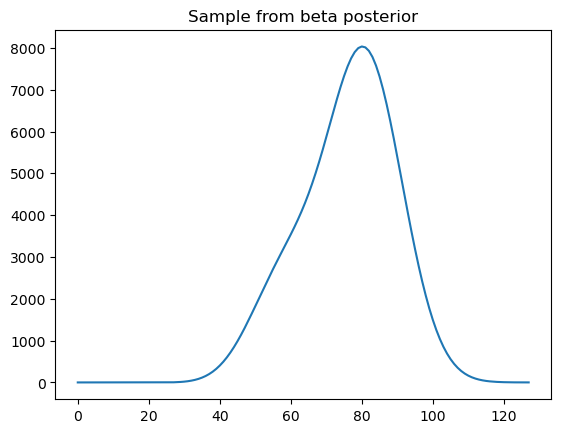

In [7]:
beta_p = np.random.multivariate_normal(m,Kst)
plt.plot(beta_p)
plt.title('Sample from beta posterior')


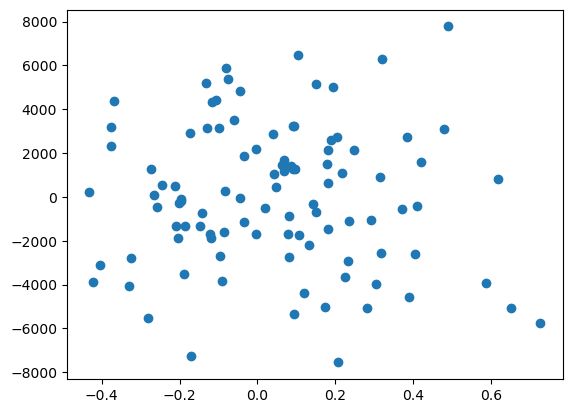

In [8]:
# Predict Y_i from the beta_p
y_pred = np.zeros(n) # np.random.multivariate_normal(np.zeros(n),S + sigma * np.identity(n))
err1=np.random.normal(mu,sigma,n)
for i in np.arange(0,n):
    y_pred[i] = mu + rect(t0,t1,x[i,:]*beta_p) + sigma *err1[i]

# Confront with the true Y_i
plt.scatter(y,y_pred)

#### Kst is not symmetric positive semidefinite, let's try to fix that

In [9]:
def is_positive_semidef(matrix):
    try:
        np.linalg.cholesky(matrix)
        return True
    except np.linalg.LinAlgError as e:
        if "Matrix is not positive definite" in str(e):
            return True 
        else:
            return False


In [10]:
is_positive_semidef(K0)

True

In [11]:
np.array_equal(K0,K0.T) 

False

So $K^{0}$ is positive semidefinite but not symmetric, we can fix that by rounding the values

In [12]:
sym_K0 = (K0 + K0.T) / 2

In [13]:
K0-sym_K0 #how much are we loosing?

array([[ 0.00000000e+00,  3.31548606e-04,  8.84918600e-04, ...,
        -2.93915548e-01, -2.31083794e-01, -1.79720644e-01],
       [-3.31548606e-04,  0.00000000e+00,  5.92110660e-04, ...,
        -3.35701620e-01, -2.65368702e-01, -2.07393313e-01],
       [-8.84918600e-04, -5.92110660e-04,  0.00000000e+00, ...,
        -3.73425906e-01, -2.97196490e-01, -2.33673032e-01],
       ...,
       [ 2.93915548e-01,  3.35701620e-01,  3.73425906e-01, ...,
         0.00000000e+00, -2.15474684e-03, -4.07709112e-03],
       [ 2.31083794e-01,  2.65368702e-01,  2.97196490e-01, ...,
         2.15474684e-03,  0.00000000e+00, -1.95090239e-03],
       [ 1.79720644e-01,  2.07393313e-01,  2.33673032e-01, ...,
         4.07709112e-03,  1.95090239e-03,  0.00000000e+00]])

In [14]:
is_positive_semidef(M)

True

In [15]:
np.array_equal(M,M.T)

True

For M we are good.  $L^{0}{'}M^{-1}L^{0}$ should still be symmetric and positive semidefinite, however:

In [16]:
is_positive_semidef(np.dot(np.transpose(L0),np.dot(np.linalg.inv(M),L0)))

True

In [17]:
np.array_equal(np.dot(np.transpose(L0),np.dot(np.linalg.inv(M),L0)),np.dot(np.transpose(L0),np.dot(np.linalg.inv(M),L0)).T)

False

Let's fix also this:

In [18]:
sym_temp = (np.dot(np.transpose(L0),np.dot(np.linalg.inv(M),L0))+np.dot(np.transpose(L0),np.dot(np.linalg.inv(M),L0)).T) / 2

In [19]:
sym_temp-np.dot(np.transpose(L0),np.dot(np.linalg.inv(M),L0))

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [20]:
new_Kst=sigma**2*(sym_K0-sym_temp)
np.array_equal(new_Kst,new_Kst.T)

True

In [21]:
is_positive_semidef(new_Kst)

True

C:\Users\Silvia\AppData\Local\Temp\ipykernel_26768\2086384928.py:2: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  beta_p = np.random.multivariate_normal(m,new_Kst)


Text(0.5, 1.0, 'Sample from beta posterior')

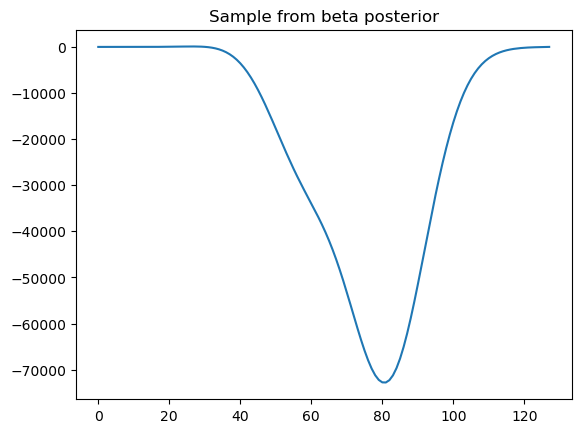

In [22]:
#let's try sim again
beta_p = np.random.multivariate_normal(m,new_Kst)
plt.plot(beta_p)
plt.title('Sample from beta posterior')

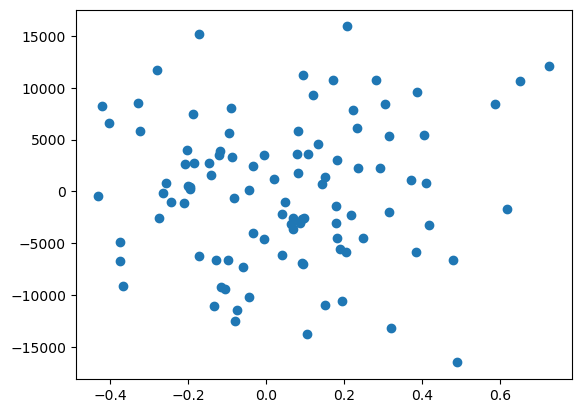

In [23]:
# Predict Y_i from the beta_p
y_pred = np.zeros(n)

err1=np.random.normal(mu,sigma,n)
for i in np.arange(0,n):
    y_pred[i] = mu + rect(t0,t1,x[i,:]*beta0_hat) + sigma *err1[i]

# Confront with the true Y_i
plt.scatter(y,y_pred)